In [25]:
# coding: utf-8
import multiprocessing
from collections import Counter
import xgboost as xgb
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm
from sklearn.model_selection import KFold
import gc
from sklearn import preprocessing
from scipy.stats import entropy
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve
import datetime
import time
from itertools import product

nowtime = datetime.date.today()
nowtime = str(nowtime)[-5:]
print(nowtime)
warnings.filterwarnings('ignore')

07-25


In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum()
    print('内存占用{:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()
    print('优化后内存为: {:.2f} MB'.format(end_mem))
    print('内存使用减少 {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [14]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [15]:
train = reduce_mem_usage(train)

内存占用63600128.00 MB
优化后内存为: 18900128.00 MB
内存使用减少 70.3%


In [16]:
train.head()

,customer_id,main_account_loan_no,main_account_active_loan_no,main_account_overdue_no,main_account_outstanding_loan,main_account_sanction_loan,main_account_disbursed_loan,sub_account_loan_no,sub_account_active_loan_no,sub_account_overdue_no,...,main_account_tenure,sub_account_tenure,disburse_to_sactioned_ratio,active_to_inactive_act_ratio,year_of_birth,disbursed_date,Credit_level,employment_type,age,loan_default
0,105691,4,3,0,384989,666207,666207,0,0,0,...,81,0,1.00,2.500000,1968,2019,1,0,51,0
1,24938,7,2,0,268670,387994,387994,0,0,0,...,161,0,1.00,1.330078,1992,2019,9,0,27,0
2,104389,5,4,1,3519013,3613854,3576048,0,0,0,...,3576048,0,0.99,3.000000,1991,2019,13,1,28,0
3,54688,43,13,6,1867106,2484678,2486856,0,0,0,...,0,0,1.00,1.419922,1964,2019,3,1,55,0
4,63894,0,0,0,0,0,0,0,0,0,...,0,0,1.00,1.000000,1995,2019,-1,0,24,0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    150000 non-null  int32  
 1   main_account_loan_no           150000 non-null  int16  
 2   main_account_active_loan_no    150000 non-null  int16  
 3   main_account_overdue_no        150000 non-null  int8   
 4   main_account_outstanding_loan  150000 non-null  int32  
 5   main_account_sanction_loan     150000 non-null  int32  
 6   main_account_disbursed_loan    150000 non-null  int32  
 7   sub_account_loan_no            150000 non-null  int8   
 8   sub_account_active_loan_no     150000 non-null  int8   
 9   sub_account_overdue_no         150000 non-null  int8   
 10  sub_account_outstanding_loan   150000 non-null  int32  
 11  sub_account_sanction_loan      150000 non-null  int32  
 12  sub_account_disbursed_loan    

In [18]:
# 数值类型
numerical_feature = list(train.select_dtypes(exclude=['object']).columns)
numerical_feature

['customer_id',
 'main_account_loan_no',
 'main_account_active_loan_no',
 'main_account_overdue_no',
 'main_account_outstanding_loan',
 'main_account_sanction_loan',
 'main_account_disbursed_loan',
 'sub_account_loan_no',
 'sub_account_active_loan_no',
 'sub_account_overdue_no',
 'sub_account_outstanding_loan',
 'sub_account_sanction_loan',
 'sub_account_disbursed_loan',
 'disbursed_amount',
 'asset_cost',
 'branch_id',
 'supplier_id',
 'manufacturer_id',
 'area_id',
 'employee_code_id',
 'mobileno_flag',
 'idcard_flag',
 'Driving_flag',
 'passport_flag',
 'credit_score',
 'main_account_monthly_payment',
 'sub_account_monthly_payment',
 'last_six_month_new_loan_no',
 'last_six_month_defaulted_no',
 'average_age',
 'credit_history',
 'enquirie_no',
 'loan_to_asset_ratio',
 'total_account_loan_no',
 'sub_account_inactive_loan_no',
 'total_inactive_loan_no',
 'main_account_inactive_loan_no',
 'total_overdue_no',
 'total_outstanding_loan',
 'total_sanction_loan',
 'total_disbursed_loan',
 

In [19]:
len(numerical_feature)

53

In [20]:
# 连续型变量
serial_feature = []
# 离散型变量
discrete_feature = []
# 单值变量
unique_feature = []

for fea in numerical_feature:
    temp = train[fea].nunique()# 返回的是唯一值的个数
    if temp == 1:
        unique_feature.append(fea)
     # 自定义变量的值的取值个数小于10就为离散型变量    
    elif temp <= 10:
        discrete_feature.append(fea)
    else:
        serial_feature.append(fea)

In [21]:
serial_feature

['customer_id',
 'main_account_loan_no',
 'main_account_active_loan_no',
 'main_account_overdue_no',
 'main_account_outstanding_loan',
 'main_account_sanction_loan',
 'main_account_disbursed_loan',
 'sub_account_loan_no',
 'sub_account_active_loan_no',
 'sub_account_outstanding_loan',
 'sub_account_sanction_loan',
 'sub_account_disbursed_loan',
 'disbursed_amount',
 'asset_cost',
 'branch_id',
 'supplier_id',
 'area_id',
 'employee_code_id',
 'credit_score',
 'main_account_monthly_payment',
 'sub_account_monthly_payment',
 'last_six_month_new_loan_no',
 'last_six_month_defaulted_no',
 'average_age',
 'credit_history',
 'enquirie_no',
 'loan_to_asset_ratio',
 'total_account_loan_no',
 'sub_account_inactive_loan_no',
 'total_inactive_loan_no',
 'main_account_inactive_loan_no',
 'total_overdue_no',
 'total_outstanding_loan',
 'total_sanction_loan',
 'total_disbursed_loan',
 'total_monthly_payment',
 'outstanding_disburse_ratio',
 'main_account_tenure',
 'sub_account_tenure',
 'disburse_to

In [22]:
discrete_feature

['sub_account_overdue_no',
 'manufacturer_id',
 'Driving_flag',
 'passport_flag',
 'employment_type',
 'loan_default']

In [23]:
for f in discrete_feature:
    print(f, '类型数：', train[f].nunique())

sub_account_overdue_no 类型数： 8
manufacturer_id 类型数： 10
Driving_flag 类型数： 2
passport_flag 类型数： 2
employment_type 类型数： 3
loan_default 类型数： 2


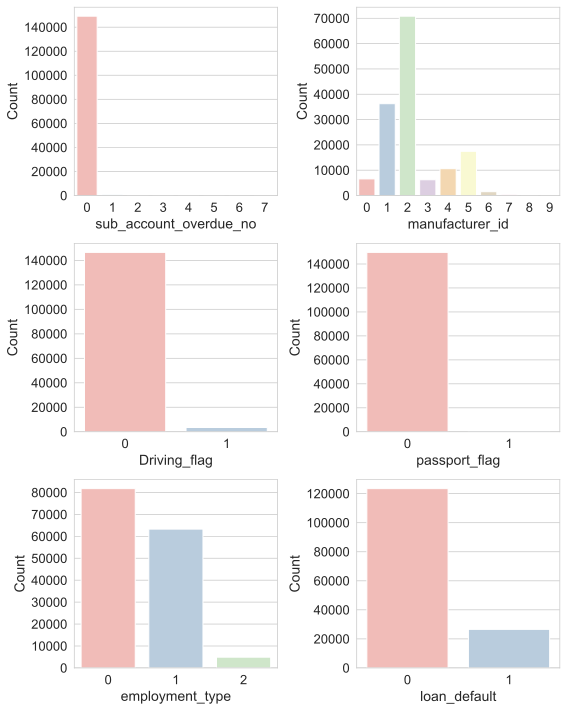

In [26]:
df_ = train[discrete_feature]

sns.set_style("whitegrid") # 使用whitegrid主题
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(8,10))
for i, item in enumerate(df_):
    plt.subplot(3,2,(i+1))
    #ax=df[item].value_counts().plot(kind = 'bar')
    ax=sns.countplot(item,data = df_,palette="Pastel1")
    plt.xlabel(str(item),fontsize=14)   
    plt.ylabel('Count',fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
#     plt.title("Churn by "+ str(item))
    i=i+1
    plt.tight_layout()
plt.show()

In [27]:
unique_feature

['mobileno_flag', 'idcard_flag', 'disbursed_date']

In [28]:
# 分类型特征
category_feature = list(filter(lambda x: x not in numerical_feature,list(train.columns)))
category_feature

[]

In [30]:
# label=train.loan_default 
# label=train.passport_flag 
label=train.sub_account_overdue_no
label.value_counts()/len(label)

0    0.994273
1    0.004773
2    0.000580
3    0.000233
4    0.000080
5    0.000027
6    0.000027
7    0.000007
Name: sub_account_overdue_no, dtype: float64

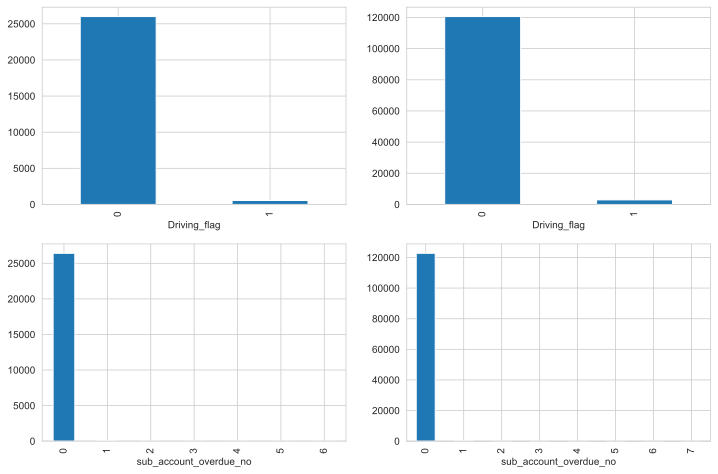

In [32]:
train_loan_fr = train.loc[train['loan_default'] == 1]
train_loan_nofr = train.loc[train['loan_default'] == 0]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8)) 
# 目标变量为1时候manufacturer_id的分布
train_loan_fr.groupby("Driving_flag").size().plot.bar(ax=ax1)
# 目标变量为0时候manufacturer_id的分布
train_loan_nofr.groupby("Driving_flag")["Driving_flag"].count().plot.bar(ax=ax2)
# 目标变量为1时候employment_type的分布
train_loan_fr.groupby("sub_account_overdue_no").size().plot.bar(ax=ax3)
# 目标变量为0时候employment_type的分布
train_loan_nofr.groupby("sub_account_overdue_no")["sub_account_overdue_no"].count().plot.bar(ax=ax4)
plt.xticks(rotation=90);